## Příprava 
Neprve si data stáhneme a podíváme se, co je uvnitř. Data jsou uložena v knihovním formátu MARC s koncovnkou .mrc. 
Pro práci budeme používat knihovnu pymarc, která dokáže marcový formát jednodušše načíst.   
Nejprve si vypíšeme, jak takový záznam vypadá.  

In [100]:
from pymarc import MARCReader

# 'data/csv/ucla_B.csv'
# 'data/csv/ucla_ret.csv'
# 'data/csv/ucla_smz.csv'
# 'data/csv/ucla_int.csv'
# 'data/csv/ucla_cle.csv'
# 'data/csv/ucla_trl.csv'

# Cesta k marcovemu dokumentu
database = 'data/ucla/ucla_cle.mrc'

# Otevreni souboru
with open(database, 'rb') as data:
    # Nacteni marcu
    reader = MARCReader(data)

    # Iterace skrz nacteny soubor
    for record in reader:
        # Vypsani marcovych zaznamu
        print(record)

        # Chceme vypsat pouze jeden zaznma, tak po prvnim vypsani zavolame funkci break
        break


=LDR  00875nab a22003134a 4500
=001  001457852
=003  CZ\PrUCL
=005  20220321104606.0
=008  090923e197808\\xr\\\\\\\\\\\\|||\||cze\d
=035  \\$a(ISIS-B70-MFN)78971
=035  \\$a(ISIS-B70-ID)785001
=040  \\$aABB060$bcze
=080  \\$a7.01$2MRF
=080  \\$a(0:82-4)$2MRF
=100  1\$aKliment, Alexandr,$d1929-2017$7jk01060558$4aut
=245  10$aKultura je když... /$cAlexandr Kliment.
=500  \\$aPodnázev zdrojového dokumentu: (London, Index on Censorship).
=520  2\$aÚvaha.
=599  \\$aCLB-CPK
=650  07$aestetika$7ph117189$2czenas
=655  \7$aúvahy$7fd134000$2czenas
=773  0\$tSpektrum$gR. 1978, č. 1, srpen, s. 77-79$q1978:1<77$9197808
=964  \\$aB70
=964  \\$aSMZ
=964  \\$aCLE
=OWN  \\$aUCLA
=SIF  \\$afk
=910  \\$aABB060
=ZAZ  \\$d197808$s1978$z1$l77



Vidíme, že marcový soubor má jasnou strukuru. Má několik polí, která jsou označena zpravidla třemi číslicem, případně třemi písmeny. Každý kód má svou vnitřní logiku, např. pole pro věcné popisy vždy začínají číslicí 6XX.



In [101]:
# Otevreni souboru
with open(database, 'rb') as data:
    # Nacteni marcu
    reader = MARCReader(data)

    # Iterace skrz nacteny soubor
    for record in reader:
        # Vypsani marcovych zaznamu
        # K nekterym zaznamum muzeme pristupovat pres teckovou notaci, tedy record.leader nebo record.title 
        print("Záznam: " + record.leader)
        
        # Pred vypsanim je standardem se nejprve podivat, zda zaznam existuje (tedy ze neni None). 
        # Pokud bychom se totiz snazili vypsat None zaznam, kod by vyhodil error. 
        if record.title is not None:
            print("Nazev: " + record.title)
        if record.author is not None:
            print("Autor: " + record.author)
        # Pokud chceme zjistit, zda pole ktere nema teckovou notaci neni None, je potreba zavolat funci .get_field(), pripadne .get_field()     
        if record.get_fields('655') is not None:    
            # K polim, ktere nemaji teckovou notaci, se pristupuje pres zavorky 
            print("Žánr: " + record['655']['a'])
        break        

Záznam: 00875nab a22003134a 4500
Nazev: Kultura je když... /
Autor: Kliment, Alexandr, 1929-2017 jk01060558 aut
Žánr: úvahy


Také by nás mohlo zajímat, kolik záznamů je v dané databázi. K tomu si muzeme vytvorit samostatnou funkci, kterou pak jen zavolame

In [102]:
# Vlastni funkce definujeme pomoci slova def
def number_of_records(database):
    with open(database, 'rb') as data:
    # Nacteni marcu
        reader = MARCReader(data)
        # Vytvorime counter, ke kteremu pri kazdem zaznamu pricteme jednicku
        counter = 0
        # Vzhledem k tomu, ze record nepotrebujeme, tak muzeme pouzit _, ktere hodnotu bude ignorovat 
        for _ in reader:
            counter += 1
    return counter 

print("V databazi je " + str(number_of_records(database)) + " zaznamu.")        

V databazi je 9612 zaznamu.


Teď je potřeba si marcová data uložit do jednodušší tabulky, se kterou později budeme pracovat. V této fázi si musíme ujasnit, jaká data budeme chtít zpracovat. V našem příkladu si budeme chtít uložit název, autora, autorův kód, rok vydání a pak pole '600','650' a '655'. 
Veškeré záznamy začínající číslem 6XX jsou věcné údaje o záznamu. Všechna pole se mohou opakovat.
Pod polem '600' se skrývají osoby, o kterých záznam je nebo případně osoby, kterým je záznam dedikován. 
Pod polem '650' se nacházejí věcné termíny/téma, tzn. o čem záznam je.
Pod polem '655' pak najdeme žánr daného záznamu. Na rozdíl od polí '600' a '650' by pole '655' mělo být přítomné u každého záznamu. 

K tomu jsme si napsali funkci save_to_dict(record, dict, field_list), která nám jeden záznam(record) uloží do slovníku dict. Protože si nebudeme chtít uložit všechny pole v záznamu, předáme funkci save_to_dict také seznam polí field_list, která budeme chtít uložit. Seznam field_list sestává z tuplů (kolekce v jazyce Python), kde každý tuple vypadá následovně. Na první pozici je název klíče, pod kterým bude pole uloženo, na druhé pozici tag pole a na třetí tag podpole, např. ('author', '100', 'a'). 

In [103]:
def save_to_dict(record, dict, field_list):
    if not record is None:
        try:
            # Iterace skrz tuples v seznamu field_list
            for field_tags in field_list:
                # Nazev klice ve slovniku
                dict_key_name =  field_tags[0]

                # Tag pole
                tag =  field_tags[1]

                # Tag podpole
                subfield_tag =  field_tags[2]
                
                # Seznam do ktereho pridame hodnoty a nasledne pridame do slovniku
                dict_add_list = []
                
                # Iterace pres vsechna pole s tagem 'tag'
                for field in record.get_fields(tag):
                    
                    # Pokud pole nema zadna podpole, pridame cele pole do listu dict_add_list
                    if subfield_tag is None:
                        dict_add_list.append(str(field))
                    
                    # Pokud subtag je instance slice, tedy to znamena, ze chceme jen nejakou cast pole, ktera neni definovana subpolem,
                    # pridame cast pole do slovniku dict_add_list    
                    elif isinstance(subfield_tag, slice):
                        dict_add_list.append(str(field) [subfield_tag])     
                    
                    # Pokud pole obsahuje podpole, pridame do slovniku dict_add_list jen podpole
                    elif '$'+subfield_tag in str(field):  
                        dict_add_list.append(str(field[subfield_tag]))

                # Do klice z tuplu pridame cely seznam dict_add_list         
                dict[dict_key_name].append(dict_add_list)
        except Exception as error:
            print("Exception: " + type(error).__name__)  
            print("964 Field: " + str(record.get_fields('964')))  
            print("LDR: " + str(record.leader))   
    return dict 

In [104]:
import pandas as pd

out = 'data/out.csv'

with open(database, 'rb') as data:
    reader = MARCReader(data)
    # Seznam poli, ktere si chceme ulozit
    field_list = [('title', '245', 'a'),
                ('author', '100', 'a'),
                ('author code', '100', '7'),
                # Rok je schovany v poli 008 na 13. az 16. miste, 
                # proto vyuzijeme funkci slice
                ('year', '008', slice(13,17, None)),
                ('figures', '600', 'a'),
                ('description', '650', 'a'),
                ('genre', '655', 'a'),
                ('magazine', '773', 't')]
    dict = {}
    for t in field_list:
        dict_key_name = t[0]
        dict[dict_key_name] = []
    for record in reader:
        dict = save_to_dict(record, dict, field_list)
    df = pd.DataFrame.from_dict(dict)

    # U jmen si chceme ulozit jmeno a prijmeni bez koncove carky ',', ktera je na konci stringu
    df['figures'] = df['figures'].apply(lambda x: [y[:y.rfind(',')] if isinstance(y, str) and len(y) > 0 else y for y in x]) 
    df['author'] = df['author'].apply(lambda x: [y[:y.rfind(',')] if isinstance(y, str) and len(y) > 0 else y for y in x])  

    # Aby se nam list hodnot lepe ukladal, vytvorime z listu jeden string a jednotlive elementy spojime strednikem ';' 
    for column in df.columns:
        df[column] = df[column].apply(lambda x: ';'.join(x))
    df.to_csv(out, encoding = 'utf8', sep = ",")     

Teď, když máme hodnoty uložené v csv, bude mnohem jednodušší s nimi pracovat.
Uložená data načteme pomocí knihovny pandas do datové struktury DataFrame (která je podobná např. excelovské tabulce). 
Řádky v DataFramu reprezentují jednotlivé záznamy, sloupce pak jeden typ (např. jmeno autora)
Některá podpole mohou opakovat, ty jsou  v csv spojené středníkem. 
POZOR: Kvůli obecnosti jsou veškeré hodnoty uloženy v listu. 

In [105]:
import pandas as pd
from collections import Counter
import numpy 

out = 'data/out.csv'

# Cesta k nasim datum
csv_data = out

# Nacteni dat
df = pd.read_csv(csv_data, delimiter=',')
# Odstraneni zbytecneho sloupce
df = df.drop(['Unnamed: 0'], axis = 1)

for column in df.columns:
    if df[column].dtype != 'int64':   
        # Hodnoty spojene v jeden string zpatky rozdelime do listu, aby se nam s nim lepe pracovalo
        df[column] = df[column].apply(lambda x: x.split(';') if isinstance(x, str)  else [])


year
1948      Jandáček, Antonín
1949      Dresler, Jaroslav
1950          Demetz, Peter
1951          Demetz, Peter
1952        Peška, Vladimír
1953          Vlach, Robert
1954        Hostovský, Egon
1955          Vlach, Robert
1956         Želivan, Pavel
1957          Vlach, Robert
1958              Den, Petr
1959              Den, Petr
1960      Dresler, Jaroslav
1961              Den, Petr
1962              Den, Petr
1963              Den, Petr
1964              Den, Petr
1965              Den, Petr
1966              Den, Petr
1967              Den, Petr
1968              Den, Petr
1969              Den, Petr
1970              Den, Petr
1971    Kratochvil, Antonín
1972    Kratochvil, Antonín
1973    Kratochvil, Antonín
1974      Dresler, Jaroslav
1975    Kratochvil, Antonín
1976      Dresler, Jaroslav
1977      Dresler, Jaroslav
1978      Dresler, Jaroslav
1979      Dresler, Jaroslav
1980           Kovtun, Jiří
1981    Kratochvil, Antonín
1982    Kratochvil, Antonín
1983      Dresl

In [ ]:
# Vybereme sloupec, ktery chceme zobrazit
picked_column = 'author'
# Data ocistime o prazdne hodnoty
data_filtered = df[df[picked_column].apply(lambda x: len(x) > 0)]
# Data shlukneme podle nejcastejsiho elementu v danem roce
most_common = data_filtered.groupby('year')[picked_column].apply(lambda x: Counter(topic for topics in x for topic in topics).most_common(1)[0][0] if len(x) > 0 else None) 

# Nejcastejsi hodnoty vypiseme
print(most_common)        


Ted si je vykreslime v jednoduchem grafu.

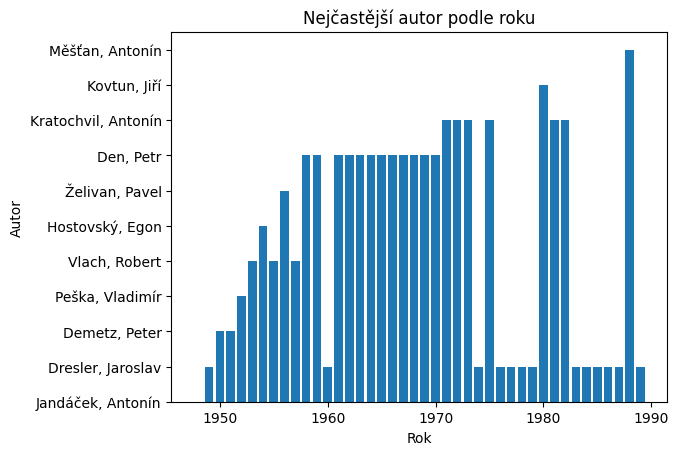

In [106]:
import matplotlib.pyplot as plt

# Prevedeme nasi promennou se shluklymi daty do datove kolekce dictionary
most_common_dict = most_common.to_dict()

# Z nej vytvorime dva listy
years = list(most_common_dict.keys())
elements = list(most_common_dict.values())

# Nektere datasety obsahuji mnoho let, proto si zvolime okno, ktere chceme zobrazit
window = (1900,max(years))

filtered_years = []
filtered_elements = []

# Vyfiltrujeme jen ty elementy, ktere jsou v okne
for year, element in zip(years, elements):
    if window[0] < year < window[1] and element is not None:
        filtered_years.append(year)
        filtered_elements.append(element)

# Hodnoty jednoduse vykreslime bar chartem a pridame popis os
plt.bar(filtered_years, filtered_elements)
plt.xlabel('Rok')
plt.ylabel('Autor')
plt.title('Nejčastější autor podle roku')
plt.show()
